# Time Series Forecasting using XGBoost for Traffic Incidents
 
 Original code taken from https://medium.com/@oemer.aslantas/a-real-world-example-of-predicting-sales-volume-using-xgboost-with-gridsearch-on-a-jupyternotebook-c6587506128d

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree
#from german_holidays import get_german_holiday_calendar
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Preparing the data

In this step, let's prepare our dataset to get daily Traffic incidents, and some extra features like daily, weekly and week day values. We will use the data from 2016, the date from which ¨Vision Cero¨ began to be implemented.

In [3]:
df = pd.read_csv('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Modelo_predictivo_siniestralidad/XGBoost/siniestros_con_hipotesis.csv')

In [4]:
df['LOCALIDAD'].unique()

array(['Engativá', 'Suba', 'Ciudad Bolívar', 'Chapinero', 'Kennedy',
       'San Cristóbal', 'Fontibón', 'Puente Aranda', 'Bosa', 'Usme',
       'Los Mártires', 'Usaquén', 'Teusaquillo', 'Barrios Unidos',
       'Tunjuelito', 'La Candelaria', 'Santa Fe', 'Rafael Uribe Uribe',
       'Antonio Nariño', 'Sumapaz'], dtype=object)

In [5]:
df = df[(df['ANO']>=2018)]

In [6]:
siniestros = pd.DataFrame(df.groupby('FECHA')['CODIGO_SINIESTRO'].count().reset_index(name='Cantidad_siniestros'))
siniestros['FECHA'] = pd.to_datetime(siniestros['FECHA'])
siniestros = siniestros.sort_values(by=['FECHA'])
siniestros.set_index('FECHA', inplace=True)
siniestros.head()

,Cantidad_siniestros
FECHA,
2018-01-01,46
2018-01-02,61
2018-01-03,122
2018-01-04,73
2018-01-05,73


In [7]:
main_df = siniestros.copy()

In [8]:
main_df.index.rename('From', inplace=True)

In [9]:
main_df

,Cantidad_siniestros
From,
2018-01-01,46
2018-01-02,61
2018-01-03,122
2018-01-04,73
2018-01-05,73
...,...
2019-12-27,83
2019-12-28,63
2019-12-29,50


In [10]:
main_df.describe()

,Cantidad_siniestros
count,730.000000
mean,98.552055
std,22.919449
min,29.000000
25%,86.000000
50%,103.000000
75%,114.000000
max,155.000000


In [11]:
main_df.isnull().sum()

Cantidad_siniestros    0
dtype: int64

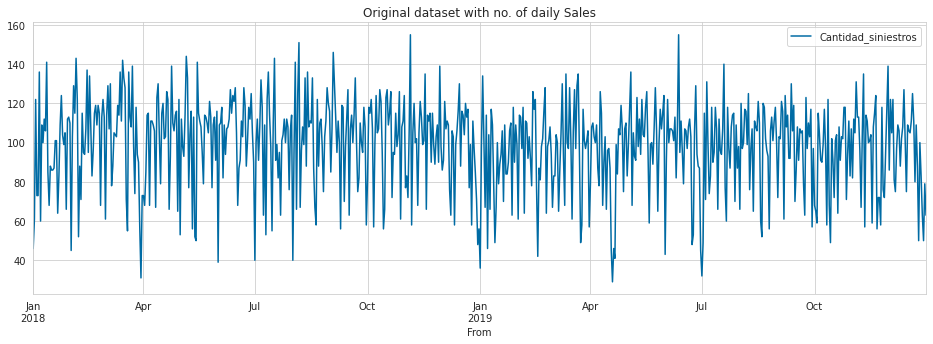

In [12]:
main_df.plot(figsize=(16,5))
plt.title('Original dataset with no. of daily Sales')
plt.show()

As we can see above, the dataset gets more stable from 2016 to now. We should be aware of this before setting the cut-line for the training dataset

In [13]:
training_df = main_df.groupby(['From'])['Cantidad_siniestros'].sum().reset_index()
training_df['Date'] = pd.to_datetime(training_df['From']).dt.date

training_df['From'] = pd.to_datetime(training_df['From'])

In [14]:
training_df.set_index('From', inplace=True)
training_df = training_df['2016-01-01':]
training_df.head()

,Cantidad_siniestros,Date
From,,
2018-01-01,46,2018-01-01
2018-01-02,61,2018-01-02
2018-01-03,122,2018-01-03
2018-01-04,73,2018-01-04
2018-01-05,73,2018-01-05


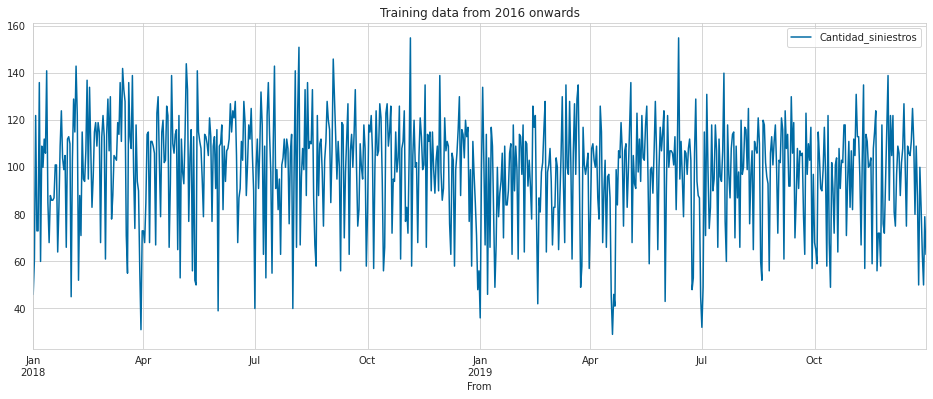

In [15]:
training_df.plot(figsize=(16,6))
plt.title('Training data from 2016 onwards')
plt.show()

Voilà, now the training data seems to be predictible.

In [16]:
training_df.describe()

,Cantidad_siniestros
count,730.000000
mean,98.552055
std,22.919449
min,29.000000
25%,86.000000
50%,103.000000
75%,114.000000
max,155.000000


In [17]:
# Extracting More info, setting features for the XGBoost
training_df['Year'] = pd.to_datetime(training_df['Date']).dt.year
training_df['Week'] = pd.to_datetime(training_df['Date']).dt.week
training_df['Day'] = pd.to_datetime(training_df['Date']).dt.day
training_df['WeekDay'] = pd.to_datetime(training_df['Date']).dt.dayofweek
training_df['Weekend'] = training_df.WeekDay.isin([5, 6]).astype(int)
training_df.head()

,Cantidad_siniestros,Date,Year,Week,Day,WeekDay,Weekend
From,,,,,,,
2018-01-01,46,2018-01-01,2018,1,1,0,0
2018-01-02,61,2018-01-02,2018,1,2,1,0
2018-01-03,122,2018-01-03,2018,1,3,2,0
2018-01-04,73,2018-01-04,2018,1,4,3,0
2018-01-05,73,2018-01-05,2018,1,5,4,0


In [18]:
training_df.corr()

,Cantidad_siniestros,Year,Week,Day,WeekDay,Weekend
Cantidad_siniestros,1.000000,-1.174062e-01,3.940155e-02,1.417425e-02,-0.183347,-2.296053e-01
Year,-0.117406,1.000000e+00,5.757183e-17,5.532736e-19,0.000684,3.369328e-19
Week,0.039402,5.757183e-17,1.000000e+00,7.105919e-02,0.005783,2.930869e-03
Day,0.014174,5.532736e-19,7.105919e-02,1.000000e+00,-0.001354,-3.406651e-03
WeekDay,-0.183347,6.843499e-04,5.782952e-03,-1.353510e-03,1.000000,7.905433e-01
Weekend,-0.229605,3.369328e-19,2.930869e-03,-3.406651e-03,0.790543,1.000000e+00


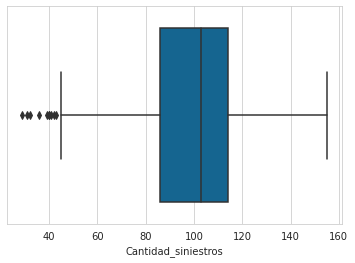

In [19]:
sns.boxplot(x=training_df['Cantidad_siniestros'])
plt.show()

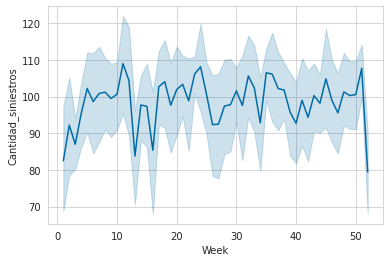

In [20]:
sns.lineplot(training_df['Week'], training_df['Cantidad_siniestros'])
plt.show()

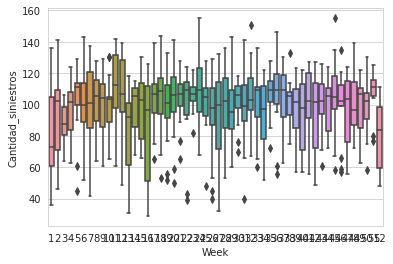

In [21]:
sns.boxplot(training_df['Week'], training_df['Cantidad_siniestros'])
plt.show()

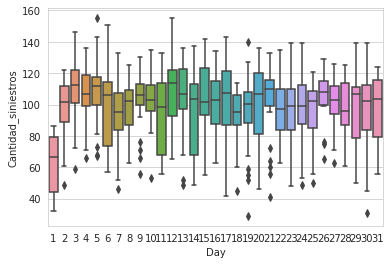

In [22]:
sns.boxplot(training_df['Day'], training_df['Cantidad_siniestros'])
plt.show()

In [23]:
training_df.drop(['Date'], axis=1, inplace=True)
print(training_df.dtypes)
print(training_df.size)
training_df.head()

Cantidad_siniestros    int64
Year                   int64
Week                   int64
Day                    int64
WeekDay                int64
Weekend                int64
dtype: object
4380


,Cantidad_siniestros,Year,Week,Day,WeekDay,Weekend
From,,,,,,
2018-01-01,46,2018,1,1,0,0
2018-01-02,61,2018,1,2,1,0
2018-01-03,122,2018,1,3,2,0
2018-01-04,73,2018,1,4,3,0
2018-01-05,73,2018,1,5,4,0


# Train/Test Split

Cut off the data after 1st Jan 2019 to use as our validation set.

In [24]:
split_date = '2019-12-01'
df_train = training_df.loc[training_df.index <= split_date].copy()
df_test = training_df.loc[training_df.index > split_date].copy()

# Create Time Series Features

Extract various time series features

In [25]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[[
        'dayofweek', 'dayofyear',
        'dayofmonth'
    ]]
    if label:
        y = df[label]
        return X, y
    return X

In [26]:
X_train, y_train = create_features(df_train, label='Cantidad_siniestros')
X_test, y_test = create_features(df_test, label='Cantidad_siniestros')

# Create XGBoost Model

## Tunning the hyper parameters with grid search

In [27]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}

# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')

grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train)

gridcv_xgb = grid.best_estimator_
print(r2_score(y_test, gridcv_xgb.predict(X_test)))

0.5133868267280748


R²-score =0.47328593566394905

## Feature Importances

This is a metric that simply sums up how many times each feature is split on.

We can see that the dayofyear of year was most commonly used to split trees, while dayofmonth and weekofyear came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

In [ ]:
import joblib
joblib.dump(gridcv_xgb, "model_xgboost_final.joblib")

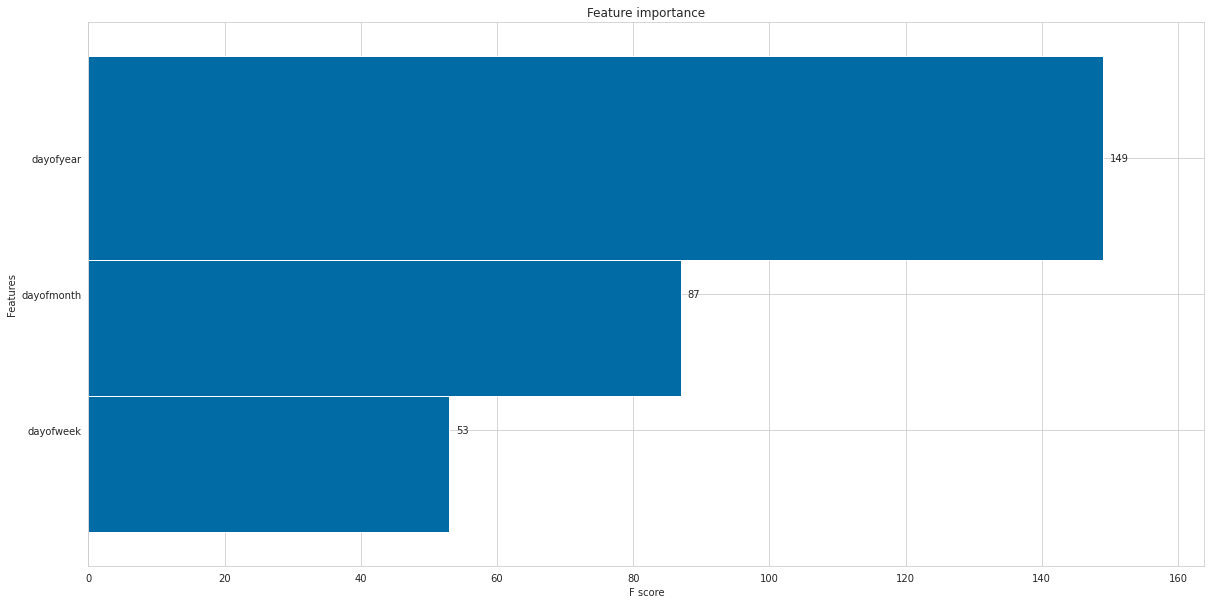

In [87]:
_ = plot_importance(gridcv_xgb, height=1.5)

# Forecast on Test Set

In [88]:
df_test['Prediction'] = gridcv_xgb.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

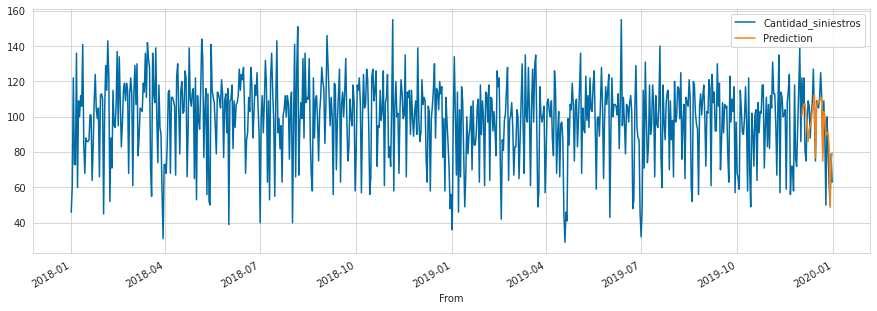

In [89]:
_ = df_all[['Cantidad_siniestros','Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

In [90]:
df_all.head().T

From,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06
Cantidad_siniestros,122,105,122,81,75
Year,2019,2019,2019,2019,2019
Week,49,49,49,49,49
Day,2,3,4,5,6
WeekDay,0,1,2,3,4
Weekend,0,0,0,0,0
date,2019-12-02 00:00:00,2019-12-03 00:00:00,2019-12-04 00:00:00,2019-12-05 00:00:00,2019-12-06 00:00:00
hour,0,0,0,0,0
dayofweek,0,1,2,3,4
quarter,4,4,4,4,4


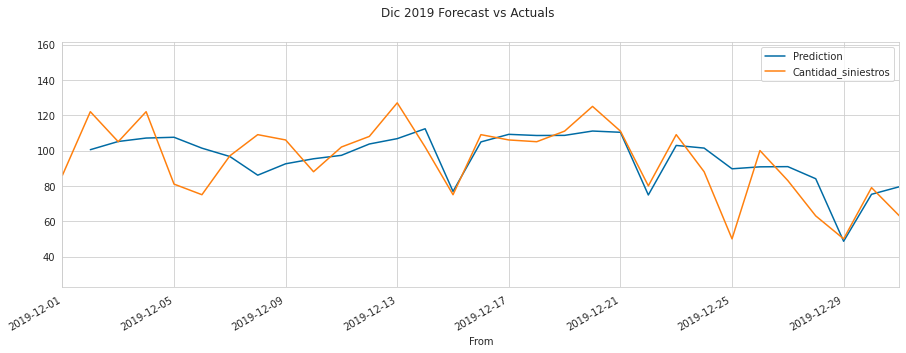

In [91]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['Prediction','Cantidad_siniestros']].plot(ax=ax, style=['-','-'])
ax.set_xbound(lower='2019-12-01', upper='2019-12-31')
plot = plt.suptitle('Dic 2019 Forecast vs Actuals')

In [92]:
mean_squared_error(y_true=df_test['Cantidad_siniestros'],
                   y_pred=df_test['Prediction'])

211.465323983566

In [93]:
mean_absolute_error(y_true=df_test['Cantidad_siniestros'],
                   y_pred=df_test['Prediction'])

10.899680201212565

In [94]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [95]:
mean_absolute_percentage_error(y_true=df_test['Cantidad_siniestros'],
                   y_pred=df_test['Prediction'])

13.1330682588849

a very good MAPE for the first our first attempt

# Look at Worst and Best Predicted Days

In [ ]:
df_test['error'] = df_test['Cantidad_siniestros'] - df_test['Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year', 'month', 'dayofmonth']) \
    .mean()[['Cantidad_siniestros', 'Prediction', 'error', 'abs_error']]

In [ ]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head()

Cantidad_siniestros  Prediction      error  abs_error
year month dayofmonth                                                       
2019 12    6                            75  104.909676 -29.909676  29.909676
           25                           50   78.762527 -28.762527  28.762527
           5                            81  106.738098 -25.738098  25.738098
           28                           63   84.182518 -21.182518  21.182518
           31                           63   78.989494 -15.989494  15.989494

In [ ]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head()

Cantidad_siniestros  Prediction     error  abs_error
year month dayofmonth                                                      
2019 12    30                           79   80.408539 -1.408539   1.408539
           16                          109  106.846779  2.153221   2.153221
           21                          111  113.774773 -2.774773   2.774773
           22                           80   76.898369  3.101631   3.101631
           29                           50   46.350704  3.649296   3.649296

# Forecasting

In [ ]:
test = pd.read_excel('predictionempty2.xlsx', parse_dates=[0], index_col=[0])
pred_x, pred_y = create_features(test, label='Sales')

test['xgb_Prediction'] = gridcv_xgb.predict(pred_x)

test.head(100)

,Sales,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,xgb_Prediction
Date,,,,,,,,,,,
2020-01-01,NaN,2020-01-01,0,2,1,1,2020,1,1,1,51.604774
2020-01-02,NaN,2020-01-02,0,3,1,1,2020,2,2,1,87.473076
2020-01-03,NaN,2020-01-03,0,4,1,1,2020,3,3,1,104.935646
2020-01-04,NaN,2020-01-04,0,5,1,1,2020,4,4,1,90.377167
2020-01-05,NaN,2020-01-05,0,6,1,1,2020,5,5,1,88.558098
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-05,NaN,2020-04-05,0,6,2,4,2020,96,5,14,91.355644
2020-04-06,NaN,2020-04-06,0,0,2,4,2020,97,6,15,101.172791
2020-04-07,NaN,2020-04-07,0,1,2,4,2020,98,7,15,91.107681


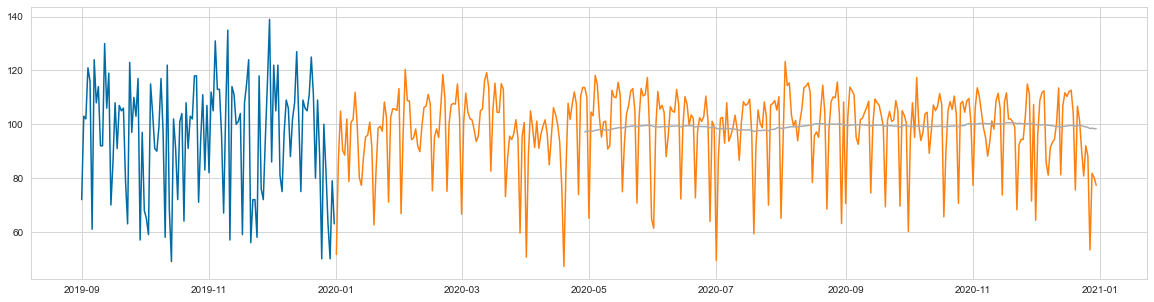

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(training_df['Cantidad_siniestros']['20190901':'20191231'])
plt.plot(test.xgb_Prediction)
plt.plot(t)
plt.show()

In [ ]:
test.to_excel('Prediction.xlsx')

In [ ]:
t = test.xgb_Prediction.rolling(window=60).mean()

<AxesSubplot:xlabel='Date'>

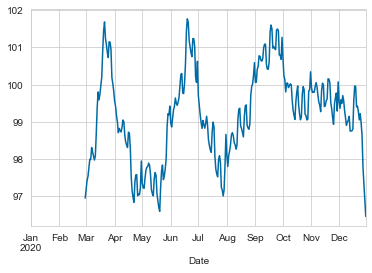

In [ ]:
plt.figure(figsize=(20,5))
t.plot()

In [ ]:
test.xgb_Prediction.mean()

98.3939208984375

In [ ]:
int(test.xgb_Prediction.max())

123